In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
import importlib

importlib.reload(utils)



<module 'utils' from '/home/adamdowse/PhD/SkinLesion/utils.py'>

Model: "mrpu_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mrpu_encoder (MRPUEncoder)      │ [(None, 576, 576, 64), │     1,663,472 │
│                                 │ (None, 288, 288, 128), │               │
│                                 │ (None, 144, 144, 256), │               │
│                                 │ (None, 72, 72, 512),   │               │
│                                 │ (None, 36, 36, 512)]   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mrpu_decoder (MRPUDecoder)      │ (None, 576, 576, 1)    │     6,304,833 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pyramid_dilated_conv            │ (None, 36, 36, 512)    │    10,488,320 │
│ (PyramidDilatedConv)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res2se_block_4 (Res2SEBlock)    │ (None, 36, 36, 512)    │     1,249,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,706,033 (75.17 MB)

 Trainable params: 19,703,089 (75.16 MB)

 Non-trainable params: 2,944 (11.50 KB)

x shape: (450, 600, 3)
y shape: (450, 600, 1)


I0000 00:00:1753972347.549716   42393 service.cc:152] XLA service 0x7fb8d401f6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753972347.549762   42393 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2025-07-31 15:32:27.652998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753972348.316202   42393 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-31 15:32:29.200210: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.233 = (f32[1,16,576,576]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,16,576,576]{3,2,1,0} %bitcast.6596, f32[16,16,3,3]{3,2,1,0} %bitcast.6603, f32[16]{0} %bitcast.6605), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target=

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


I0000 00:00:1753972359.310908   42393 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


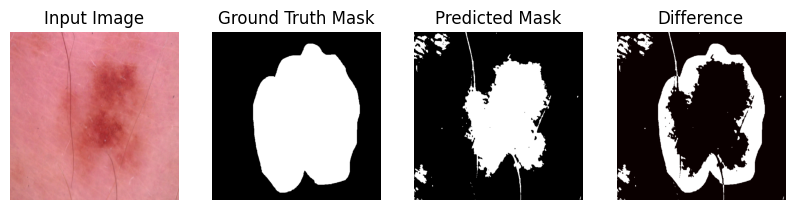

In [7]:
# load model

from Models import Res2NetBlock, SEBlock, PyramidDilatedConv, ImageScaleLayer, Res2SEBlock, MRPUEncoder, MRPUDecoder, MRPUNet

num_classes = 1
new_model = MRPUNet(num_classes=num_classes)

# 2. Build the model
input_shape = (576, 576, 3)
new_model.build(input_shape=(None,) + input_shape)

# 3. Load weights directly from the .keras file
# Replace 'path/to/your/model.keras' with the actual file path
new_model.load_weights('/home/adamdowse/PhD/SkinLesion/Models/MRPUNet.keras')

# Your model is now ready
new_model.summary()

x = tf.image.decode_jpeg(tf.io.read_file("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/Images/ISIC_0024307.jpg"), channels=3)
y = tf.image.decode_png(tf.io.read_file("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/SegmentationMaps/ISIC_0024307_segmentation.png"), channels=1)

print("x shape:", x.shape)
print("y shape:", y.shape)

# Preprocess the input image
x = tf.image.resize(x, (576, 576))
x = tf.expand_dims(x, axis=0)  # Add batch dimension
x = tf.cast(x, tf.float32) / 255.0  # Normalize to [0, 1] range
y = tf.image.resize(y, (576, 576))
y = tf.cast(y > 0, tf.float32)
y = tf.expand_dims(y, axis=0)  # Add batch dimension

# Predict using the model
predictions = new_model.predict(x)

#show the predictions

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(x[0])
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(y[0, :, :, 0], cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')
plt.subplot(1, 4, 3)
predictions[0, :, :, 0] = np.clip(predictions[0, :, :, 0], 0, 1)  # Ensure predictions are in [0, 1]
#threshold the predictions to create a binary mask
predictions[0, :, :, 0] = (predictions[0, :, :, 0] > 0.5).astype(np.float32)
plt.imshow(predictions[0, :, :, 0], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
#plot the difference between the predicted mask and the ground truth mask
plt.subplot(1, 4, 4)

plt.imshow(np.abs(predictions[0, :, :, 0] - y[0, :, :, 0]), cmap='hot')
plt.title('Difference')
plt.axis('off')
plt.show()

In [8]:
# use the dataset to calculate the value features and save to a CSV file with image names
#Ground Truth Features
model = utils.FeatureExtractionModel()
data_dir = "/home/adamdowse/PhD/SkinLesion/Data/HAM10000"
batch_size = 4
image_size = (576, 576)
dataset = utils.create_segmentation_dataset(data_dir, image_size=image_size, batch_size=batch_size, train=True)
output_csv_path = "/home/adamdowse/PhD/SkinLesion/Data/HAM10000/test_value_customseg0.25_features.csv"
utils.save_predictions_to_dataframe(model, seg_model=new_model, dataset=dataset, output_csv_path=output_csv_path, threshold=0.25)

# #Custom segmentation model features
# model = utils.FeatureExtractionModel()
# data_dir = "/home/adamdowse/PhD/SkinLesion/Data/HAM10000"
# batch_size = 4
# image_size = (576, 576)
# dataset = utils.create_segmentation_dataset(data_dir, image_size=image_size, batch_size=batch_size, train=True)
# output_csv_path = "/home/adamdowse/PhD/SkinLesion/Data/HAM10000/test_value_customseg_features.csv"
# utils.save_predictions_to_dataframe(model, new_model, dataset, output_csv_path,threshold=None)


Processing dataset:   0%|          | 0/2128 [00:00<?, ?it/s]2025-07-31 15:32:50.095805: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-31 15:32:51.606413: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-31 15:32:51.606474: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were availa

Instructions for updating:
Use fn_output_signature instead


I0000 00:00:1753972374.504141   42387 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x2a9bca40
Processing dataset: 100%|██████████| 2128/2128 [19:39<00:00,  1.80it/s]

Predictions saved to /home/adamdowse/PhD/SkinLesion/Data/HAM10000/test_value_customseg0.25_features.csv


In [ ]:
# Hair removal 
# black circle impact
# build classification model with:
    # single value features - XGboost
    # image features - CNN
    # mask midpoint features - CNN

       image_id  asymmetry_iou  asymmetry_colour  compact_index  \
0  ISIC_0030665       0.000316          0.042334      1403.7811   
1  ISIC_0028735       0.015490          0.002894      3759.7808   
2  ISIC_0027648       0.015490          0.002164      3136.6987   
3  ISIC_0025771       0.000316          0.034593      1321.7240   
4  ISIC_0031344       0.000538          0.001058      1713.9553   

   fractal_dimension  border_gradient  dx  
0           2.736633         0.118938  df  
1           3.220581         0.231721  df  
2           3.860175         0.196428  df  
3           4.062667         0.162196  df  
4           3.291111         0.153416  df  
       image_id  asymmetry_iou  asymmetry_colour  compact_index  \
0  ISIC_0030665       0.048602          0.060348      1502.7836   
1  ISIC_0028735       0.033433          0.026847     16866.5180   
2  ISIC_0027648       0.033433          0.029497      8874.1580   
3  ISIC_0025771       0.048602          0.056827      1396.3881  

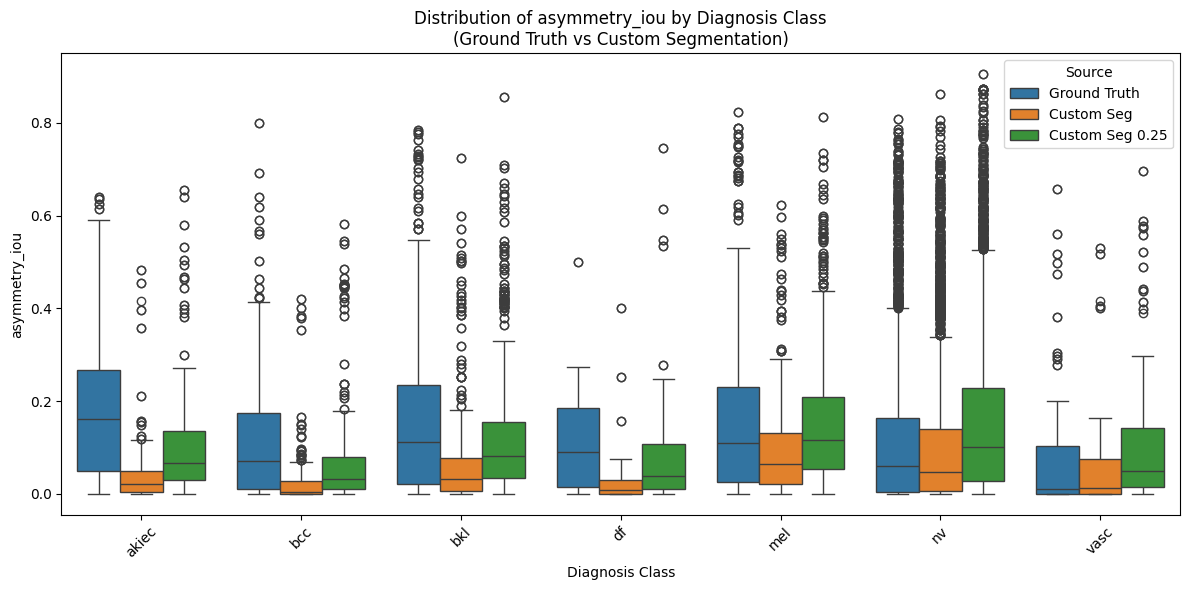

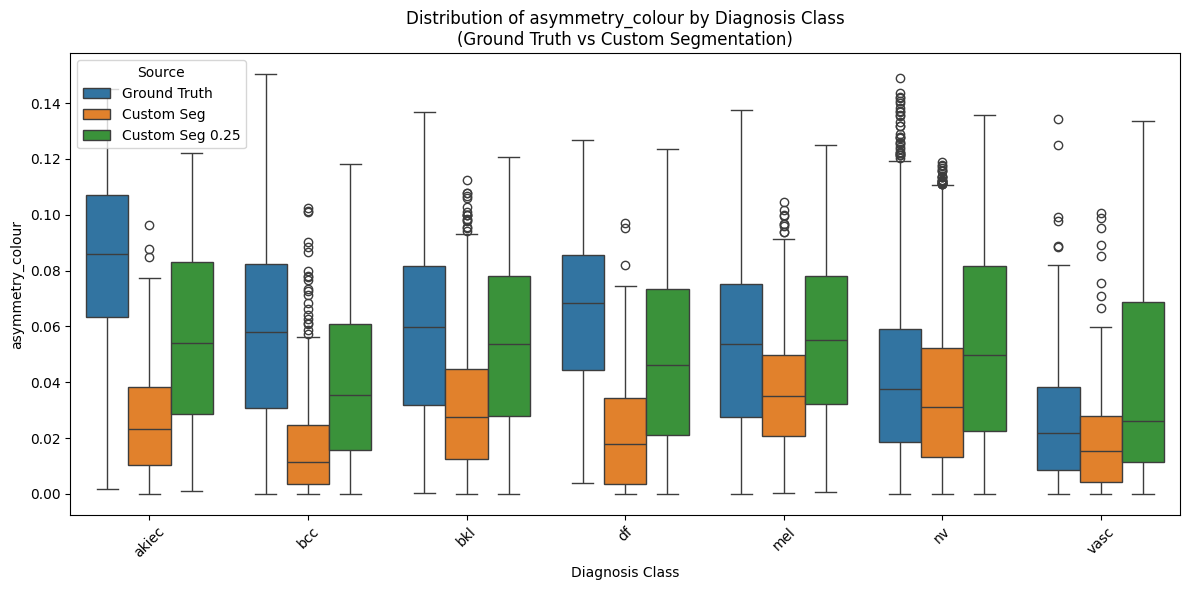

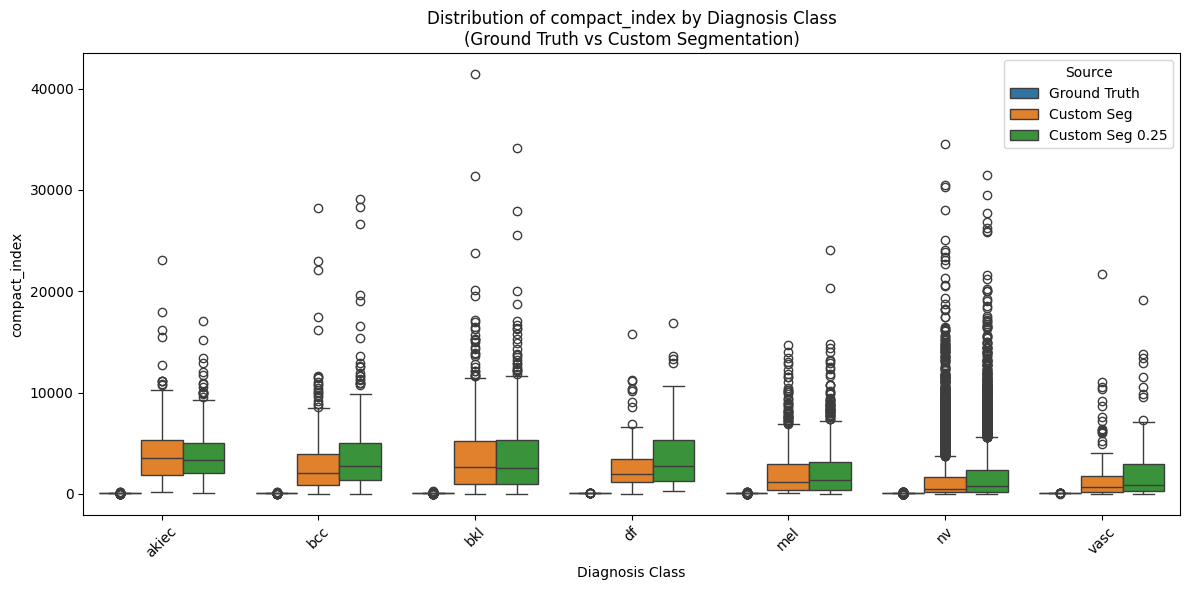

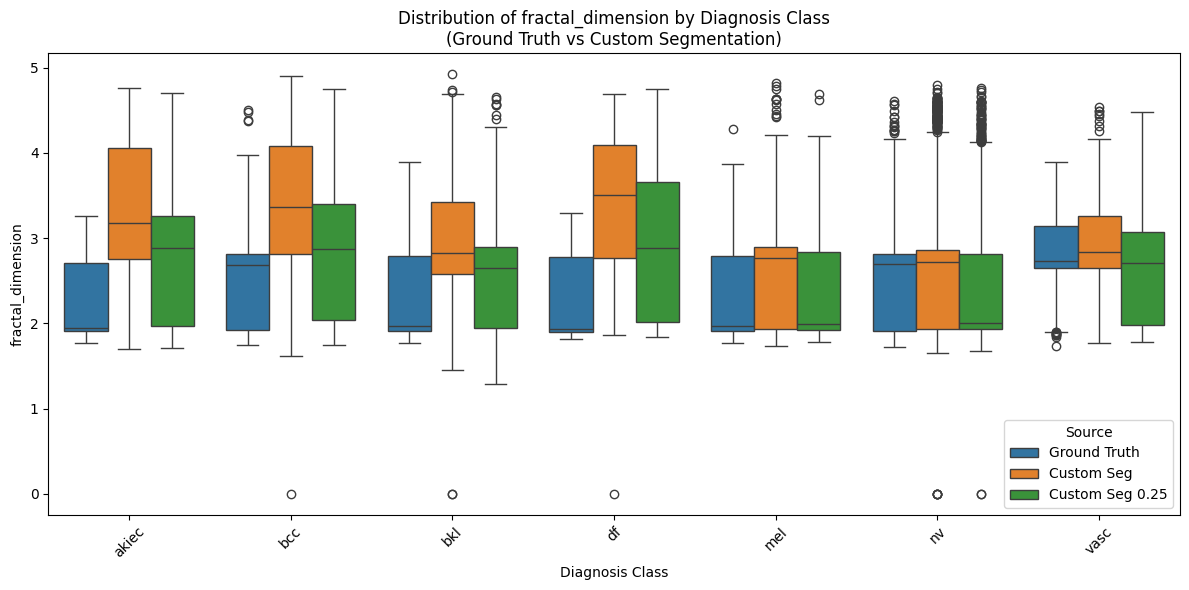

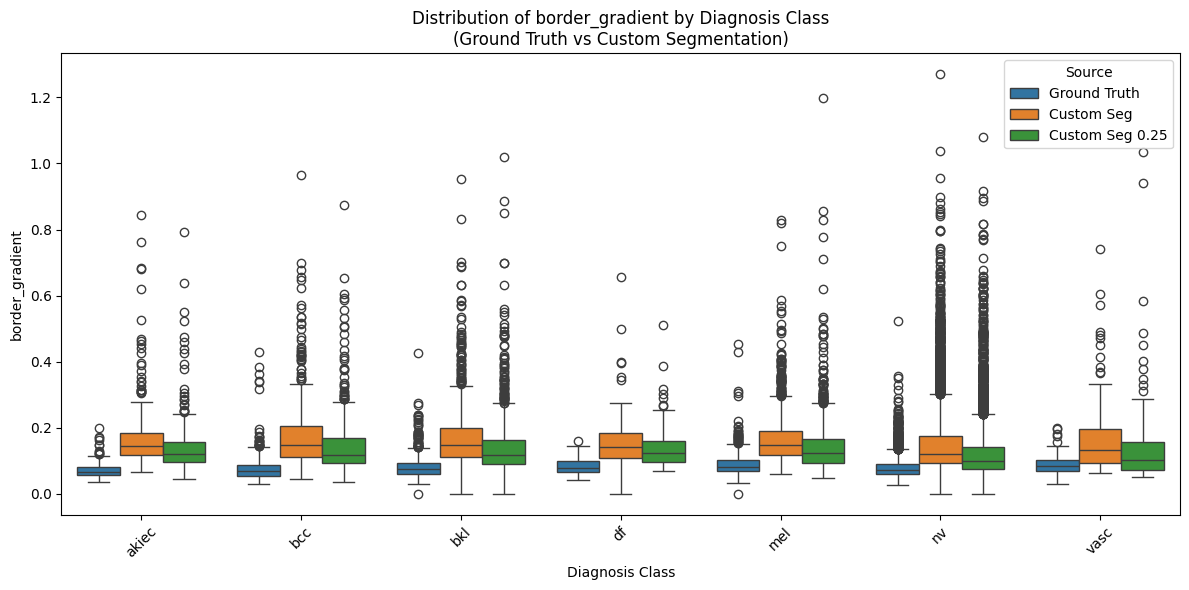

In [10]:
#view the features
gt_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_features.csv")
gt_features_df['image_name'] = gt_features_df['image_name'].str.replace('.jpg', '', regex=False)
gt_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
gt_features_df = gt_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')


c_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_customseg_features.csv")
c_features_df['image_name'] = c_features_df['image_name'].str.replace('.jpg', '', regex=False)
c_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
c_features_df = c_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')
print(c_features_df.head())

c5_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_customseg0.25_features.csv")
c5_features_df['image_name'] = c5_features_df['image_name'].str.replace('.jpg', '', regex=False)
c5_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
c5_features_df = c5_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')
print(c5_features_df.head())


#for each dx class, calculate the mean and std of each feature
feature_columns = ['asymmetry_iou', 'asymmetry_colour', 'compact_index', 'fractal_dimension', 'border_gradient']
# for feature in feature_columns:
#     mean_std = features_df.groupby('dx')[feature].agg(['mean', 'std']).reset_index()
#     print(f"Feature: {feature}")
#     print(mean_std)
#     print("\n")

# print("length of features_df:", len(features_df))
# print("Unique dx classes:", features_df['dx'].unique())


gt_features_df['source'] = 'Ground Truth'
c_features_df['source'] = 'Custom Seg'
c5_features_df['source'] = 'Custom Seg 0.25'

# Concatenate the DataFrames
combined_df = pd.concat([gt_features_df, c_features_df,c5_features_df], ignore_index=True)

all_classes = sorted(combined_df['dx'].unique())
combined_df['dx'] = pd.Categorical(combined_df['dx'], categories=all_classes, ordered=True)


feature_columns = ['asymmetry_iou', 'asymmetry_colour', 'compact_index', 'fractal_dimension', 'border_gradient']

for feature in feature_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='dx', y=feature, hue='source',
        data=combined_df,
        dodge=True,
    )
    plt.title(f'Distribution of {feature} by Diagnosis Class\n(Ground Truth vs Custom Segmentation)')
    plt.xlabel('Diagnosis Class')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Source')
    plt.show()

       image_id  gt_asymmetry_iou  gt_asymmetry_colour  gt_compact_index  \
0  ISIC_0030665          0.039523             0.070689         76.568825   
1  ISIC_0028735          0.000000             0.003905         73.931244   
2  ISIC_0027648          0.000000             0.065289         78.545500   
3  ISIC_0025771          0.039523             0.052799         77.407640   
4  ISIC_0031344          0.000000             0.083435         88.945465   

   gt_fractal_dimension  gt_border_gradient  dx  c_asymmetry_iou  \
0              1.848153            0.080842  df         0.000316   
1              3.101131            0.098048  df         0.015490   
2              2.801478            0.066321  df         0.015490   
3              2.877944            0.099928  df         0.000316   
4              1.909511            0.046346  df         0.000538   

   c_asymmetry_colour  c_compact_index  c_fractal_dimension  \
0            0.042334        1403.7811             2.736633   
1       

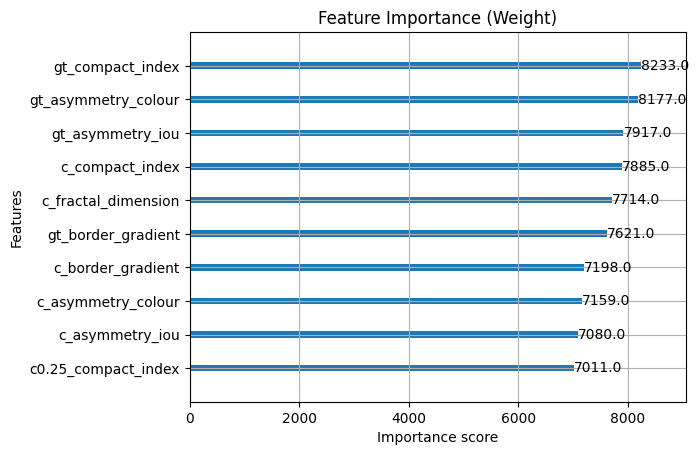

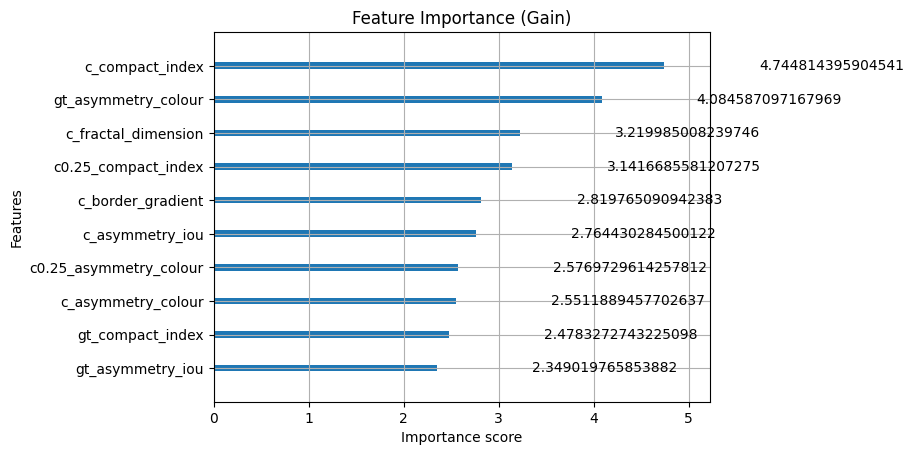

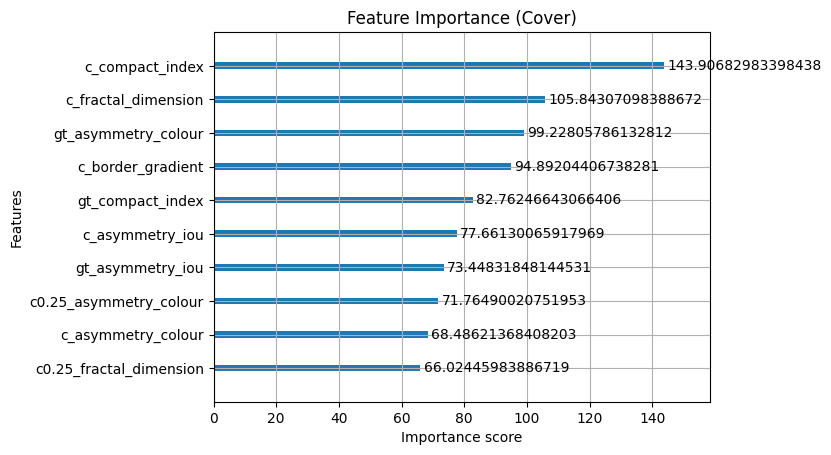

In [23]:
#train xgboost on combined_df
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Prepare the data for XGBoost
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
gt_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_features.csv")
gt_features_df['image_name'] = gt_features_df['image_name'].str.replace('.jpg', '', regex=False)
gt_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
#rename the features to include the source
gt_features_df.rename(columns={col: f'gt_{col}' for col in feature_columns}, inplace=True)

c_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_customseg_features.csv")
c_features_df['image_name'] = c_features_df['image_name'].str.replace('.jpg', '', regex=False)
c_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
#rename the features to include the source
c_features_df.rename(columns={col: f'c_{col}' for col in feature_columns}, inplace=True)
# Merge the features together

c5_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_customseg0.25_features.csv")
c5_features_df['image_name'] = c5_features_df['image_name'].str.replace('.jpg', '', regex=False)
c5_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
#rename the features to include the source
c5_features_df.rename(columns={col: f'c0.25_{col}' for col in feature_columns}, inplace=True)
# Merge the features together
combined_df = gt_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')
combined_df = combined_df.merge(c_features_df, on='image_id', how='left')
combined_df = combined_df.merge(c5_features_df, on='image_id', how='left')

print(combined_df.head())
new_feature_columns = [f'gt_{col}' for col in feature_columns] + [f'c_{col}' for col in feature_columns] + [f'c0.25_{col}' for col in feature_columns]
#noralize the features
for col in new_feature_columns:
    combined_df[col] = (combined_df[col] - combined_df[col].mean()) / combined_df[col].std()

X = combined_df[new_feature_columns]
y = combined_df['dx']

from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(combined_df['dx'])


dtrain = xgb.DMatrix(X, label=y_encoded)
params = {
    'objective': 'multi:softmax',
    'num_class': len(all_classes),
    'eval_metric': 'mlogloss',
    'max_depth': 10,
    'eta': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}
num_round = 100
bst = xgb.train(params, dtrain, num_round)
# Evaluate the model
y_pred = bst.predict(dtrain)
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_encoded, y_pred, target_names=all_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_encoded, y_pred))
# feature importance
xgb.plot_importance(bst, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (Weight)')
plt.show()
xgb.plot_importance(bst, importance_type='gain', max_num_features=10)
plt.title('Feature Importance (Gain)')
plt.show()
xgb.plot_importance(bst, importance_type='cover', max_num_features=10)
plt.title('Feature Importance (Cover)')
plt.show()

In [43]:
#Train an XGBoost model on the both sets of features
import xgboost as xgb
# Prepare the data for XGBoost
gt_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_features.csv")
gt_features_df['image_name'] = gt_features_df['image_name'].str.replace('.jpg', '', regex=False)
gt_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
gt_features_df = gt_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')

c_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/train_value_customseg_features.csv")
c_features_df['image_name'] = c_features_df['image_name'].str.replace('.jpg', '', regex=False)
c_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
c_features_df = c_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')


#for each dx class, calculate the mean and std of each feature
feature_columns = ['asymmetry_iou', 'asymmetry_colour', 'compact_index', 'fractal_dimension', 'border_gradient']
X_gt = gt_features_df[feature_columns].values
X_c = c_features_df[feature_columns].values

from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
le = LabelEncoder()
y_gt_encoded = le.fit_transform(gt_features_df['dx'])
y_c_encoded = le.transform(c_features_df['dx'])

#train a model for each set of features
gt_dtrain = xgb.DMatrix(X_gt, label=y_gt_encoded)
c_dtrain = xgb.DMatrix(X_c, label=y_c_encoded)

# Define the parameters for XGBoost
params = {
    'objective': 'multi:softmax',
    'num_class': len(all_classes),
    'max_depth': 13,
    'eta': 0.1,
    'eval_metric': 'mlogloss',
    'seed': 43
}
# Train the model on the ground truth features
gt_model = xgb.train(params, gt_dtrain, num_boost_round=100)
# Train the model on the custom segmentation features
c_model = xgb.train(params, c_dtrain, num_boost_round=100)

# find the accuracy of the models
gt_predictions = gt_model.predict(gt_dtrain)
c_predictions = c_model.predict(c_dtrain)

# Calculate accuracy
gt_accuracy = np.mean(gt_predictions == y_gt_encoded)
c_accuracy = np.mean(c_predictions == y_c_encoded)

print(f"Ground Truth Model Accuracy: {gt_accuracy:.2f}")
print(f"Custom Segmentation Model Accuracy: {c_accuracy:.2f}")

gt_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/test_value_features.csv")
gt_features_df['image_name'] = gt_features_df['image_name'].str.replace('.jpg', '', regex=False)
gt_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
gt_features_df = gt_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')

c_features_df = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/test_value_customseg_features.csv")
c_features_df['image_name'] = c_features_df['image_name'].str.replace('.jpg', '', regex=False)
c_features_df.rename(columns={'image_name': 'image_id'}, inplace=True)
metadata = pd.read_csv("/home/adamdowse/PhD/SkinLesion/Data/HAM10000/HAM10000_metadata.csv")
c_features_df = c_features_df.merge(metadata[['image_id', 'dx']], on='image_id', how='left')

tX_gt = gt_features_df[feature_columns].values
tX_c = c_features_df[feature_columns].values

y_gt_encoded = le.transform(gt_features_df['dx'])
y_c_encoded = le.transform(c_features_df['dx'])

gt_dtest = xgb.DMatrix(tX_gt, label=y_gt_encoded)
c_dtest = xgb.DMatrix(tX_c, label=y_c_encoded)



#test accuracy on the test set
gt_tpredictions = gt_model.predict(gt_dtest)
c_tpredictions = c_model.predict(c_dtest)
# Calculate test accuracy
gt_taccuracy = np.mean(gt_tpredictions == y_gt_encoded)
c_taccuracy = np.mean(c_tpredictions == y_c_encoded)
print(f"Ground Truth Model Test Accuracy: {gt_taccuracy:.2f}")
print(f"Custom Segmentation Model Test Accuracy: {c_taccuracy:.2f}")

Ground Truth Model Accuracy: 0.99
Custom Segmentation Model Accuracy: 1.00
Ground Truth Model Test Accuracy: 0.65
Custom Segmentation Model Test Accuracy: 0.67
